<a href="https://colab.research.google.com/github/yifan-zhou19/iso/blob/master/iso_cg_model(ffnn_lstm_cnn).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##################
# DATA IMPORTING #
##################

from os.path import exists

!wget -O cwe119_cgd.txt https://raw.githubusercontent.com/CGCL-codes/VulDeePecker/master/CWE-119/CGD/cwe119_cgd.txt

print()

with open("./cwe119_cgd.txt", "r") as cgd:
  print("Source: ",cgd.readline())

--2020-04-19 14:43:41--  https://raw.githubusercontent.com/CGCL-codes/VulDeePecker/master/CWE-119/CGD/cwe119_cgd.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17202057 (16M) [text/plain]
Saving to: ‘cwe119_cgd.txt’

cwe119_cgd.txt      100%[===================>]  16.40M  93.2MB/s    in 0.2s    

2020-04-19 14:43:42 (93.2 MB/s) - ‘cwe119_cgd.txt’ saved [17202057/17202057]


Source:  1 CVE-2010-1444/vlc_media_player_1.1.0_CVE-2010-1444_zipstream.c cfunc 449



In [3]:
import re
re_punctuation_string = '[()\s,/.\']'
programs=[]
program = []
statement=[]
labels = []
vocabulary = [] 
remove_token=['',' ',',','NULL','\n',';']
with open("./cwe119_cgd.txt", "r") as cgd:
  lines = cgd.readlines()
  for line in lines:
    statement=[token for token in re.split(re_punctuation_string,line)if token not in remove_token]
    #print(statement)
    if statement == ['---------------------------------']:
      if program[-1] == ['0']:
        labels.append(0)
      elif program[-1] == ['1']:
        labels.append(1)
      programs.append(program[1:-2])
      for s in program[1:]:
        for t in s:
           if t not in vocabulary:
             vocabulary.append(t)
      #print(program)
      program = []
    else:
      program.append(statement)

print(len(labels))


  
print(len(vocabulary))
   

39753
22631


In [0]:
# shuffle data
import random
randnum = random.randint(0,100)
random.seed(randnum)
random.shuffle(programs)
random.seed(randnum)
random.shuffle(labels)

In [5]:
#print(vocabulary[:20])
print(len([one for one in labels[:10000] if one == 1 ]))
print(len([zero for zero in labels[:10000] if zero == 0 ]))

2581
7419


In [6]:
print(len([one for one in labels[10000:15000] if one == 1 ]))
print(len([zero for zero in labels[10000:15000] if zero == 0]))


1350
3650


In [7]:
training_data = []
for i in range(10000):
  training_data.append((programs[i],labels[i]))
print(training_data[:2])

[([['#define', 'SRC_STRING', '"AAAAAAAAAA"'], ['char', '*', 'data;'], ['data', '=', 'NULL;'], ['for', 'i', '=', '0;', 'i', '<', '1;', 'i++'], ['data', '=', 'char', '*', 'malloc', '10*sizeof', 'char'], ['char', 'source[10+1]', '=', 'SRC_STRING;']], 1), ([['data[100-1]', '=', '\\0'], ['printLine', 'data']], 0)]


In [8]:
eval_data=[]
for i in range(10000,15000):
  eval_data.append((programs[i],labels[i]))
print(eval_data[:2])

[([['data[50-1]', '=', '\\0'], ['char', 'dest[50]', '=', '"";']], 0), ([['wchar_t', '*', 'data;'], ['data', '=', 'NULL;'], ['data', '=', 'new', 'wchar_t[10];'], ['badSink_b', 'data'], ['void', 'badSink_b', 'wchar_t', '*', 'data'], ['badSink_c', 'data'], ['void', 'badSink_c', 'wchar_t', '*', 'data'], ['wchar_t', 'source[10+1]', '=', 'SRC_STRING;']], 1)]


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#look up table  
#using one-hot embedding
vocabulary_size = len(vocabulary)
def look_up_table(word_idx):
  x = torch.zeros(vocabulary_size).long()
  x[word_idx] = 1.0
  return x
word2idx = {w: idx +1 for (idx, w) in enumerate(vocabulary)}
idx2word = {idx+1: w for (idx, w) in enumerate(vocabulary)}
print(look_up_table(word2idx['1']))

tensor([0, 0, 0,  ..., 0, 0, 0])


In [10]:
context_size = 20
def get_programcontext(program):
  id = 0
  contexts =torch.zeros(context_size,1).long()
  for p in program:
    for t in p:
      if id < context_size:
        contexts[id]= word2idx[t]
        id = id +1
      else:
        return contexts
  return contexts
get_programcontext(programs[4920])

tensor([[4078],
        [   5],
        [ 743],
        [4079],
        [4080],
        [   5],
        [ 168],
        [4078],
        [  99],
        [ 168],
        [4081],
        [  99],
        [ 539],
        [4082],
        [   5],
        [ 127],
        [ 638],
        [4080],
        [ 352],
        [ 151]])

In [13]:


torch.manual_seed(1)
embedding_dim =15

hidden_dim=15
class FFNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(FFNN, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.conv1 = nn.Conv2d(1, 3, 2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 2)
    self.fc1 = nn.Linear(16 * 5 * 5, 2)

    self.linear1 = nn.Linear(embedding_dim*context_size,10)
    self.linear2 = nn.Linear(10,2)
  def forward(self, inputs):
    #print(inputs.size())
    embeds = self.embeddings(inputs.view(-1))
    #print(embeds)
    out = F.relu(self.linear1(embeds.view(-1)))
    out = F.softmax(self.linear2(out),dim=0)
    return out






loss_function = nn.BCELoss()
model_ffnn = FFNN(vocabulary_size, embedding_dim)
optimizer_ffnn = optim.Adam(model_ffnn.parameters(), lr=0.001)
params = sum(p.numel() for p in model_ffnn.parameters() if p.requires_grad)
print("Total number of parameters for FFNN is: {}".format(params))





Total number of parameters for FFNN is: 343714
Total number of parameters for CNN is: 340436
Total number of parameters for LSTM is: 341417


In [27]:

torch.manual_seed(1)
embedding_dim =15

class CNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(CNN, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.conv1 = nn.Conv1d(1, 9, (5,embedding_dim),padding =(2,0))
    self.conv2 = nn.Conv2d(9, 5, (2,1))
    self.fc1 = nn.Linear(5*19, 2)

  def forward(self, inputs):
    #print(inputs.size())
    embeds = self.embeddings(inputs.view(-1))
    #print(embeds.size())
    out = self.conv1(embeds.view(1,1,context_size,embedding_dim))
    #print(out.size())
    out = self.conv2(out)
    #print(out.size())
    out = F.softmax(self.fc1(out.view(-1)),dim=0)
    return out

model_cnn = CNN(vocabulary_size, embedding_dim)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
params = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print("Total number of parameters for CNN is: {}".format(params))

Total number of parameters for CNN is: 340436


In [31]:

torch.manual_seed(1)
embedding_dim =15

hidden_dim=15



class LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(LSTM, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim)
    self.fc1 = nn.Linear(hidden_dim, 2)

  def forward(self, inputs):
    #print(inputs.size())
    embeds = self.embeddings(inputs)
    #print(embeds.size())
    lstm_out, _ = self.lstm(embeds.view(len(inputs), 1, -1))
    #print(out.size())
    out =  self.fc1(lstm_out.view(len(inputs), -1))
    #print(out.size())
    out = F.softmax(out,dim=1)
    return out[-1]

model_lstm = LSTM(vocabulary_size, embedding_dim)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)
params = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)
print("Total number of parameters for LSTM is: {}".format(params))

Total number of parameters for LSTM is: 341417


In [14]:
loss_ffnn=[]
for epoch in range(20):
  losses = 0
  for program, label in training_data:
   # print(program)
   # print(label)
   if label ==1:
     out_labels = torch.FloatTensor([0,1])
   else:
     out_labels  = torch.FloatTensor([1,0])

   context_idx = get_programcontext(program)
   model_ffnn.zero_grad()
   out = model_ffnn(context_idx)
   #print(out.size())
   #print(f'Out {out}')
   #print(out_labels)
   loss = loss_function(out, out_labels )
   #print(f'Loss {loss.item()}')
   loss.backward()
   optimizer_ffnn.step()
   #print(f'Loss {loss.item()}')
   losses +=loss.item()
  print(f'Loss at epo {epoch}: {losses/len(training_data)}')
  loss_ffnn.append(losses/len(training_data))

Loss at epo 0: 0.43017799125669137
Loss at epo 1: 0.3028090852695508
Loss at epo 2: 0.24653100898158342
Loss at epo 3: 0.21547359129801075
Loss at epo 4: 0.19763623593468932
Loss at epo 5: 0.18351433898274694
Loss at epo 6: 0.17470127702979488
Loss at epo 7: 0.1687429365884017
Loss at epo 8: 0.16281480271997553
Loss at epo 9: 0.1585997763959786
Loss at epo 10: 0.15509781577249782
Loss at epo 11: 0.15193908091117414
Loss at epo 12: 0.15023913784473533
Loss at epo 13: 0.14744943618491652
Loss at epo 14: 0.14594168134095004
Loss at epo 15: 0.14437423681088618
Loss at epo 16: 0.14256813892317297
Loss at epo 17: 0.141538108312441
Loss at epo 18: 0.1385479923384193
Loss at epo 19: 0.13803714160384728


In [29]:
loss_cnn=[]
for epoch in range(20):
  losses = 0
  for program, label in training_data:
   # print(program)
   # print(label)
   if label ==1:
     out_labels = torch.FloatTensor([0,1])
   else:
     out_labels  = torch.FloatTensor([1,0])

   context_idx = get_programcontext(program)
   model_cnn.zero_grad()
   out = model_cnn(context_idx)
   #print(out.size())
   #print(f'Out {out}')
   #print(out_labels)
   loss = loss_function(out, out_labels )
   #print(f'Loss {loss.item()}')
   loss.backward()
   optimizer_cnn.step()
   #print(f'Loss {loss.item()}')
   losses +=loss.item()
  print(f'Loss at epo {epoch}: {losses/len(training_data)}')
  loss_cnn.append(losses/len(training_data))

Loss at epo 0: 0.4329644622432694
Loss at epo 1: 0.3080646322125338
Loss at epo 2: 0.264106816858453
Loss at epo 3: 0.24187296481116938
Loss at epo 4: 0.2277713280842017
Loss at epo 5: 0.21760353947275685
Loss at epo 6: 0.20984574428133645
Loss at epo 7: 0.20360441401495546
Loss at epo 8: 0.19847366318416398
Loss at epo 9: 0.19381015862164996
Loss at epo 10: 0.18961560205682967
Loss at epo 11: 0.1856175353756958
Loss at epo 12: 0.18191200981283637
Loss at epo 13: 0.17868655303486083
Loss at epo 14: 0.175748401916963
Loss at epo 15: 0.17286334641702256
Loss at epo 16: 0.17006412490261688
Loss at epo 17: 0.1674790255540157
Loss at epo 18: 0.16511839005399626
Loss at epo 19: 0.16291598970482965


In [32]:
loss_lstm=[]
for epoch in range(20):
  losses = 0
  for program, label in training_data:
   # print(program)
   # print(label)
   if label ==1:
     out_labels = torch.FloatTensor([0,1])
   else:
     out_labels  = torch.FloatTensor([1,0])

   context_idx = get_programcontext(program)
   model_lstm.zero_grad()
   out = model_lstm(context_idx)
   #print(out.size())
   #print(f'Out {out}')
   #print(out_labels)
   loss = loss_function(out, out_labels )
   #print(f'Loss {loss.item()}')
   loss.backward()
   optimizer_lstm.step()
   #print(f'Loss {loss.item()}')
   losses +=loss.item()
  print(f'Loss at epo {epoch}: {losses/len(training_data)}')
  loss_lstm.append(losses/len(training_data))

  

Loss at epo 0: 0.4106655039300211
Loss at epo 1: 0.276416620680294
Loss at epo 2: 0.2444005040439195
Loss at epo 3: 0.22220756849476603
Loss at epo 4: 0.206825136278657
Loss at epo 5: 0.19522269151275978
Loss at epo 6: 0.1865209095785598
Loss at epo 7: 0.1765615358981522
Loss at epo 8: 0.17360264210932363
Loss at epo 9: 0.16483224221080164
Loss at epo 10: 0.16119229238703592
Loss at epo 11: 0.15704808118052607
Loss at epo 12: 0.1548087656527492
Loss at epo 13: 0.15192189801120204
Loss at epo 14: 0.14656113714115235
Loss at epo 15: 0.14484914882364563
Loss at epo 16: 0.14236343145716063
Loss at epo 17: 0.13999237054309505
Loss at epo 18: 0.13902712813158385
Loss at epo 19: 0.1389830996185602


In [18]:
with torch.no_grad():
  tp=0
  tn=0
  fp=0 
  fn = 0
  for program, label in eval_data:
   # print(program)
   # print(label)
   context_idx = get_programcontext(program)
   model_ffnn.zero_grad()
   out = model_ffnn(context_idx)
   #print(f'{out}:{label}')
   if(out[0]>0.5):
     if(label == 0):
       tn =tn+1
     else:
       fp = fp +1
   elif(out[1]>0.5):
     if(label == 1):
       tp = tp+1
     else:
       fn = fn +1
  accu=(tn+tp)/(tp+tn+fn+fp)
  pre=tp/(tp+fp)
  re=tp/(tp+fn)
  print(f'Accuracy_ffnn: {accu}') 
  print(f'Precision_ffnn: {pre}')
  print(f'Recall_ffnn: {re}')
  print(f'F1_ffnn: {2*(pre*re/(pre+re))}')  

Accuracy_ffnn: 0.8558
Precision_ffnn: 0.705925925925926
Recall_ffnn: 0.7462803445575568
F1_ffnn: 0.7255424438523032


In [30]:
with torch.no_grad():
  tp=0
  tn=0
  fp=0 
  fn = 0
  for program, label in eval_data:
   # print(program)
   # print(label)
   context_idx = get_programcontext(program)
   model_cnn.zero_grad()
   out = model_cnn(context_idx)
   #print(f'{out}:{label}')
   if(out[0]>0.5):
     if(label == 0):
       tn =tn+1
     else:
       fp = fp +1
   elif(out[1]>0.5):
     if(label == 1):
       tp = tp+1
     else:
       fn = fn +1
  accu=(tn+tp)/(tp+tn+fn+fp)
  pre=tp/(tp+fp)
  re=tp/(tp+fn)
  print(f'Accuracy_cnn: {accu}') 
  print(f'Precision_cnn: {pre}')
  print(f'Recall_cnn: {re}')
  print(f'F1_cnn: {2*(pre*re/(pre+re))}')

Accuracy_cnn: 0.8676
Precision_cnn: 0.7140740740740741
Recall_cnn: 0.7774193548387097
F1_cnn: 0.7444015444015445


In [40]:
with torch.no_grad():
  tp=0
  tn=0
  fp=0 
  fn = 0
  for program, label in eval_data:
   # print(program)
   # print(label)
   context_idx = get_programcontext(program)
   model_lstm.zero_grad()
   out = model_lstm(context_idx)
   #print(f'{out}:{label}')
   if(out[0]>0.5):
     if(label == 0):
       tn =tn+1
     else:
       fp = fp +1
   elif(out[1]>=0.5):
     if(label == 1):
       tp = tp+1
     else:
       fn = fn +1
  accu=(tn+tp)/(tp+tn+fn+fp)
  pre=tp/(tp+fp)
  re=tp/(tp+fn)
  print(f'Accuracy_lstm: {accu}') 
  print(f'Precision_lstm: {pre}')
  print(f'Recall_lstm: {re}')
  print(f'F1_lstm: {2*(pre*re/(pre+re))}')

Accuracy_lstm: 0.8638
Precision_lstm: 0.7207407407407408
Recall_lstm: 0.7619420516836335
F1_lstm: 0.7407689379520366


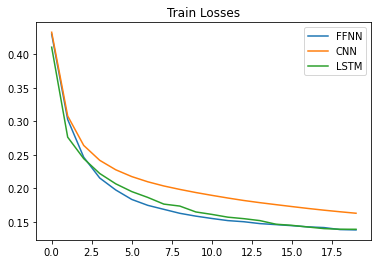

In [39]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, len(loss_ffnn))), loss_ffnn, label='FFNN')
plt.plot(list(range(0, len(loss_cnn))), loss_cnn, label='CNN')
plt.plot(list(range(0, len(loss_lstm))), loss_lstm, label='LSTM')
plt.legend()
plt.title('Train Losses')
plt.show()